<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Accessing the MUSE View of NGC 253**

This notebook demonstrates how to access and explore the MUSE data cube for the starburst galaxy NGC 253, made available as part of the **first data release of "The MUSE View of the Sculptor" programme**. The data product used in this example is:

- [ADP.2025-07-06T07:52:11.871](https://archive.eso.org/dataset/ADP.2025-07-06T07:52:11.871)

This release provides a wide-field mosaic of NGC 253 constructed from observations with the MUSE integral field spectrograph at the VLT in Wide Field Mode (WFM), using the extended wavelength configuration. The final mosaic spans approximately 20 × 5 arcminutes and is composed of 103 individual pointings. The majority of the dataset (101 pointings) was obtained without adaptive optics (AO), with exposure times of ~850 seconds. Two central pointings covering the nuclear region were observed with AO and longer integrations (~2000 seconds), improving spatial resolution in the central starburst zone. The full mosaic delivers a detailed view of the ionised gas, stellar populations, and dust in the central regions of this prototypical nearby starburst galaxy. More information about the data release can be found in the [official release description](https://www.eso.org/rm/api/v1/public/releaseDescriptions/236), and in the accompanying [ESO press release (eso2510)](https://www.eso.org/public/unitedkingdom/news/eso2510/).

<p align="center">
  <img src="https://cdn.eso.org/images/screen/eso2510a.jpg" alt="MUSE View of NGC 253" width="600"/>
  <br>
  <em>Figure: MUSE view of the Sculptor galaxy NGC 253 (Credit: ESO/PHANGS)</em>
</p>

_**Usage**: You can access this file either as a static HTML page [(download it here)](http://archive.eso.org/programmatic/HOWTO/jupyter/ESO_How_to_download_data.html), or as an interactive jupyter notebook [(download it here)](http://archive.eso.org/programmatic/HOWTO/jupyter/ESO_How_to_download_data.ipynb) which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook: move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will._

<hr style="border:2px solid #0281c9"> </hr>

## **Importing the necessary modules**

In [1]:
import os # Operating system interaction and environment variables
import sys # System and environment management

import requests # For making HTTP requests
import cgi # For making HTTP requests and handling multipart form data
import json # For handling JSON data

import getpass # For user authentication

import numpy as np  # Numerical operations and array handling
from matplotlib import pyplot as plt  # Plotting library for visualizations

from astropy.coordinates import SkyCoord  # Celestial coordinate handling and conversions
import astropy.units as u  # Physical units and quantities
from astropy.wcs import WCS  # World Coordinate System handling for celestial coordinates
from astropy.io import fits  # FITS file handling for astronomical data

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_49890/309297613.py:5: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi # For making HTTP requests and handling multipart form data


## **Define some useful functions** 

Let's define a couple of utility functions, useful to write the files on disk using the ESO file name (provided in the response http header, via the Content-Disposition field.

In [2]:
def getDispositionFilename( response ):
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename

def writeFile( response ):
    """Write on disk the retrieved file"""
    if response.status_code == 200:
        # The ESO filename can be found in the response header
        filename = getDispositionFilename( response )
        # Let's write on disk the downloaded FITS spectrum using the ESO filename:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return filename 

And also lets then define a function to get a cutout from the ESO Data Portal. This function will take parameters such as data product ID (dp_id - in the form of e.g. ADP.2025-07-06T07:52:11.871), coordinates (RA and Dec), radius, wavelength range, prefix, verbosity, and whether to download the data or not.

In [3]:
def get_cutout(dp_id, ra, dec, radius, wave_min=None, wave_max=None, prefix=None, verbose=False, download=True): 
    """Get a cutout from the ESO Data Portal. 
    """
    # base_url = "https://dataportal.eso.org/dataPortal/soda/sync?ID="
    base_url = "https://dataportal.eso.org/dataportal_new/soda/sync?ID="

    radius = np.round(radius, 6)  # Round to 6 decimal places for precision
    circle = f"CIRCLE={ra}+{dec}+{radius}" 
    band   = f"BAND={wave_min}+{wave_max}" if wave_min and wave_max else ""
    prefix = f"PREFIX={prefix}" if prefix else ""
    file_url = f"{base_url}{dp_id}&{prefix}&{circle}&{band}"

    if verbose:
        print("Requesting cutout from URL: %s" % (file_url))

    if not download:
        return file_url

    response = requests.get(file_url)
    filename = writeFile(response)
    if filename:
        print("Saved file: %s" % (filename))
    else:
        print("Could not get file (status: %d)" % (response.status_code))

    return filename  # Return the filename for further processing if needed

And a simple function to open the FITS file and return the HDU list, which can be used to inspect the contents of the FITS file.

In [4]:
def open_cutout(filename):
    """Open the FITS file and return the HDU list"""
    try:
        hdul = fits.open(filename)
        return hdul
    except Exception as e:
        print(f"Error opening file {filename}: {e}")
        return None

## **Retrieve the NGC 253 dataset**
Firstly lets download part of the NGC 253 dataset towards the centre of the galaxy and check what the Halpha emission looks like, both spectrally and spatially.

In [5]:
target = "NGC253" # The target galaxy NGC 253
dp_id = "ADP.2025-07-06T07:52:11.871" # Data product ID for the NGC 253 dataset

Here we resolve the target coordinates, and then use the `get_cutout` function to retrieve a 60 arcsec cutout of the data cube around that position, and around the Halpha+[NII] line. 

In [6]:
coords = SkyCoord.from_name(target) # Convert target name to coordinates
ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
radius = (60*u.arcsec).to("deg").value # Radius in degrees
wave_min = 652e-9  # Minimum wavelength in meters
wave_max = 662e-9  # Maximum wavelength in meters

# Get the cutout from the ESO Data Portal
filename = get_cutout(dp_id, ra, dec, radius, wave_min=wave_min, wave_max=wave_max)

# Open the cutout FITS file and return the HDU list
hdul = open_cutout(filename)

Saved file: ADP.2025-07-06T07:52:11.871_cut0.fits


Make a small function to get the wavelength axes from the FITS file, which will be useful for plotting the spectral data.

In [7]:
def get_wavelengthaxes(hdul):
    """Extract wavelength axes from the HDU list"""
    hdr = hdul[1].header
    crval = hdr["CRVAL3"]
    cdelt = hdr["CD3_3"]
    crpix = hdr["CRPIX3"]
    naxis = hdr["NAXIS3"]
    wave = crval + (np.arange(naxis) + 1 - crpix) * cdelt
    return wave

In [8]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxes(hdul) # Get the wavelength axes from the FITS file
data_cont = np.nanmedian(data, axis=0) # Median over the spectral dimension to get the (appox) continuum map
data_line = np.nansum(data - data_cont, axis=0)  # Subtract the continuum to get the line map and sum over the spectral dimension
data_spec = np.nanmean(data - data_cont, axis=(1,2))  # Subtract the continuum to get the line map and average over the spatial dimensions

Plot the spectrum of the Halpha emission line, which is the average over the spatial dimensions and continuum subtracted.

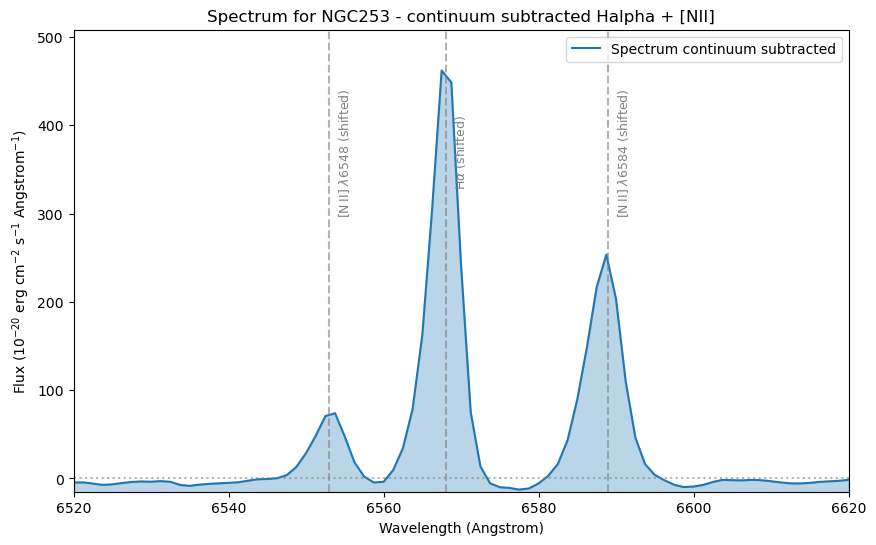

In [27]:
# Define key emission lines in Angstrom
lines = {
    r'[N II] $\lambda6548$': 6548,
    r'H$\alpha$': 6563,
    r'[N II] $\lambda6584$': 6584,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Spectrum continuum subtracted')
ax.fill_between(data_wave, -20, data_spec, where=(data_spec > -20), alpha=0.3, color='C0')
ax.hlines(0, data_wave[0], data_wave[-1], color='gray', linestyle=':', alpha=0.6)


# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave+5, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 6, np.nanmax(data_spec) * 0.8, 
                label+' (shifted)', 
                rotation=90, verticalalignment='center', fontsize=9, color='gray')

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target} - continuum subtracted Halpha + [NII]')

ax.set_ylim(-15, np.nanmax(data_spec) * 1.1)  # Set y-limits to avoid clipping
ax.set_xlim(6520, 6620)

ax.legend()

Plot the maps of the Halpha + [NII] emission and the continuum, which are the sum and median over the spectral dimension, respectively.

We also mark the position of interest on both maps - for which we will extract the full spectrum in the next step.

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_46251/701990967.py:7: RuntimeWarning: invalid value encountered in sqrt
  map1 = np.sqrt(data_line)


Text(0, 0.5, 'Y (pixels)')

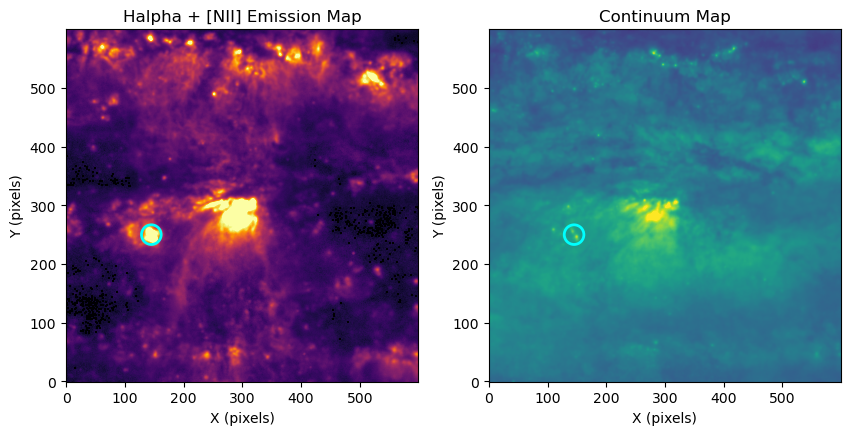

In [ ]:
pos = [145, 250]

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

map1 = np.sqrt(data_line)
map2 = np.sqrt(data_cont)

cmap1 = plt.cm.inferno
cmap2 = plt.cm.viridis
cmap1.set_bad(color=cmap1(0))
cmap2.set_bad(color=cmap2(0))

ax1.imshow(map1, origin='lower', cmap=cmap1, vmin=np.nanpercentile(map1, 0), vmax=np.nanpercentile(map1, 99.1))
ax2.imshow(map2, origin='lower', cmap=cmap2, vmin=0, vmax=np.nanpercentile(map2, 99.9))

ax1.scatter(pos[0], pos[1], color='cyan', marker='o', s=200, lw=2, fc='none')
ax2.scatter(pos[0], pos[1], color='cyan', marker='o', s=200, lw=2, fc='none')

ax1.set_title('Halpha + [NII] Emission Map')
ax2.set_title('Continuum Map')
ax1.set_xlabel('X (pixels)')
ax2.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax2.set_ylabel('Y (pixels)')

fig.tight_layout()

In [ ]:
wcs = WCS(hdul[1].header)
coords = wcs.pixel_to_world(pos[0], pos[1], 0)[0]
print(f"Position in sky coordinates: {coords.to_string('decimal')} degrees")
print(f"Position in sky coordinates: {coords.to_string('hmsdms')}")
print(f"Position in pixel coordinates: {pos[0]}, {pos[1]}")

Position in sky coordinates: 11.8974 -25.2855 degrees
Position in sky coordinates: 00h47m35.37532805s -25d17m07.84008262s
Position in pixel coordinates: 145, 250


In [15]:
target = "NGC253"
dp_id = "ADP.2025-07-06T07:52:11.871"

ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
radius = (10*u.arcsec).to("deg").value # Radius in degrees

# Get the cutout from the ESO Data Portal
filename = get_cutout(dp_id, ra, dec, radius) # Given no constraints on wavelength, we get the full cutout

# Open the cutout FITS file and return the HDU list
hdul = open_cutout(filename)

Saved file: ADP.2025-07-06T07:52:11.871_cut0.fits


In [16]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxes(hdul) # Get the wavelength axes from the FITS file
data_spec = np.nanmean(data, axis=(1,2))  # Average over the spatial dimensions

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_46251/306934521.py:3: RuntimeWarning: Mean of empty slice
  data_spec = np.nanmean(data, axis=(1,2))  # Average over the spatial dimensions


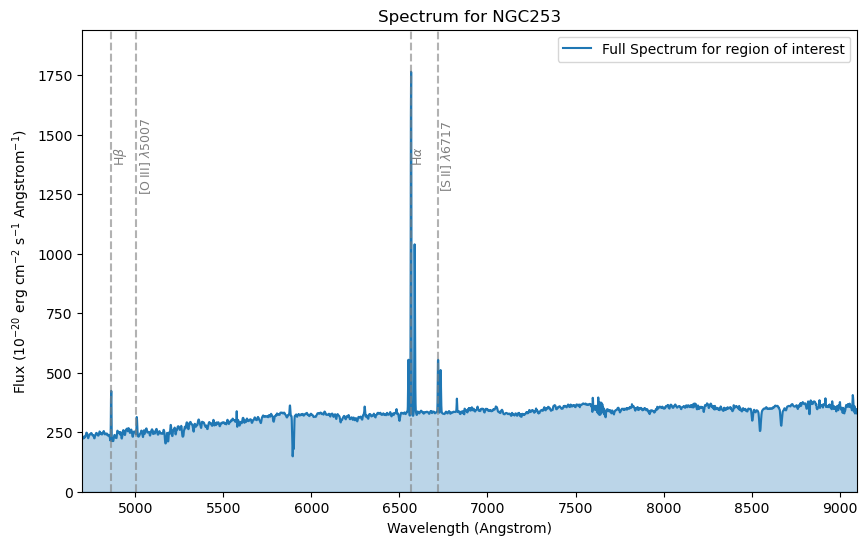

In [ ]:
# Define some key emission lines in Angstrom
lines = {
    r'H$\beta$': 4861,
    r'[O III] $\lambda5007$': 5007,
    r'H$\alpha$': 6563,
    # r'[N II] $\lambda6584$': 6584,
    r'[S II] $\lambda6717$': 6717,
    # r'[S II] $\lambda6731$': 6731,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Full Spectrum for region of interest')
ax.fill_between(data_wave, 0, data_spec, where=(data_spec > 0), alpha=0.3, color='C0')

# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 10, np.nanmax(data_spec) * 0.8, label, rotation=90,
                verticalalignment='center', fontsize=9, color='gray')

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target}')

ax.set_ylim(0, np.nanmax(data_spec) * 1.1)  # Set y-limits to avoid clipping
ax.set_xlim(4700, 9100)

ax.legend()